# Project: Predicting future NBA Most Valuable Player (MVP)

# Part 2: Cleaning, combining and manipulate data in pandas

In the second part of this project, we'll clean and prep the data we parsed in part 1 for part 3 (train a ML model to predict MVPs).

The aim is to extract, clean and combine into one dataframe the data we'll need from these 3 files:
* **mvps.csv** (Awarding ranking)
* **players.csv** (Players stats)
* **teamss.csv** (Teams stats)

We'll also do some quick data exploration at the end. 

In [198]:
import pandas as pd

In [199]:
mvps = pd.read_csv('mvps.csv')
players = pd.read_csv('players.csv')
teams = pd.read_csv('teams.csv')

## MVP votes

A lot of the stats data for players with MVP votes is in the **players** dataframe, so we'll only keep the columns we need and discard the rest:

In [200]:
#mvps

In [201]:
mvps = mvps[["Player","Year","Pts Won","Pts Max","Share"]]

In [202]:
# Sanity checks
mvps
mvps.isna().sum()
mvps.dtypes
mvps.describe()
mvps[mvps.duplicated()]

,Player,Year,Pts Won,Pts Max,Share


## Players Stats

From the **players** dataframe, we'll remove `Unnamed: 0` and `Rk` (unnecessary) and conduct a few basic checks:

In [203]:
#players

In [204]:
del players["Unnamed: 0"]
del players["Rk"]

In [205]:
# Sanity checks
players
players.isna().sum()
players.dtypes
players.describe()

players.Player.head(50)
players[players.duplicated(subset=['Player','Year'])]
players[players.Player == "Player"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
47,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,1991
70,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,1991
93,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,1991
118,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,1991
145,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19469,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,2023
19492,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,2023
19519,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,2023
19544,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,2023


Few observation:
1. There are some missing data. Seems to mostly be associated with shooting percentage, if a player hasn't got any attempted shots in a category (e.g. FT, 2pts or 3pts) the success rate will be *NaN*. **At first glance nothing to worry about, but worth keeping in mind in**.
2. All the data is saved as string rather than numerical, we'll probably need to change that for when it comes to making calcs.
3. Some players names contain a "*" (denoting that they're been granted the *Hall of Fame* status, we'll remove that character because we'll be merging **mvps** and **players** onto the `Player`and `Year`columns (*Makes sense as most players tend to play for multiple years in the NBA*).
4. Some player have multiple rows associated to a given year - this is because they've player for different teams during that season. These players have **TOT** row (marked in the `Tm`column) which represents the total stats over the season, we'll use that row and remove the others. 
5. Finally, the header row was is duplicated within the dataset (from scraping the data) - we'll remove these. 

In [206]:
# Sort out Player column (1):
players["Player"] = players["Player"].str.replace("*", "", regex=False)

In [207]:
# Remove rows that are a duplicate of the header (5):
players = players[players['Player'] != "Player"]

In [208]:
# Remove rows for players who played for multiple team in a season (keeping TOT) (4):

# This function will be applied to groupby dataframes 
def single_team(df):
    
    # If a player/year combination df only has 1 row return that df (i.e. player had 1 team that year)
    if df.shape[0] == 1:
        return df
    
    # If a player/year combination df has multiple rows, only return the row where Tm == "TOT"
    else:
        row = df[df["Tm"] == "TOT"]
        # Set the Tm to the last team the player player for (to enable to merge the teams stats later on)
        row["Tm"] = df.iloc[-1,:]["Tm"] 
        return row
    
# Apply the function above to grouped PLAYER / YEAR 
players = players.groupby(["Player", "Year"]).apply(single_team)

In [209]:
#players

In [210]:
# Because we created groups to deal with issue (4), we've created a multi-level index - we'll remove them: 
players.index = players.index.droplevel()
players.index = players.index.droplevel()

In [211]:
#players

## Merging MVP and Player dataframes

As mentioned previously, we'll on the `Player` and `Year` columns. We're obviously performing an *outer* merge to include all the players that haven't received MVP votes!

To insure consistency and avoid confusing we'll replace the *NaN* values in columns `Pts Won`, `Pts Max` and `Share` for players with no MVP votes by **0** that this merge will create. We can do this with confidence because we previously checked that the initial **mvps** dataframe didn't have *NaN* - therefore we're not generalising actual missing data.

In [212]:
# Merge the dfs
combined_df = players.merge(mvps, how="outer", on=["Player","Year"])

# Replace NaNs by 0
combined_df[["Pts Won","Pts Max","Share"]] = combined_df[["Pts Won","Pts Max","Share"]].fillna(0)

In [213]:
#combined_df

Lastly, because we know the format of our data, we know that this **combined_df** only has stores the team names as abreviations (see columns `Tm`). Therefore, in preperation for the last merge, we're going to use the **nicknames.txt** file we've got to add a complete team name column `Team` to the combined dataframe we've just created.

In [214]:
nicknames = {}
with open("nicknames.txt") as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev,name = line.replace("\n","").split(",")
        nicknames[abbrev] = name

In [215]:
combined_df["Team"] = combined_df["Tm"].map(nicknames)

In [216]:
#combined_df

## Teams Stats

Similarly to the 2 previous dataframes, we'll conduct basic checks on the **teams** df:

In [217]:
#teams

In [218]:
del teams["Unnamed: 0"]

In [219]:
#teams

In [220]:
# Sanity checks
teams
teams.isna().sum()
teams.dtypes
teams.describe()

teams.W.head(20)
teams[teams.duplicated(subset=['Team','Year'])]

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team


Again, we'll do a couple of data cleaning operation to insure we can merge this data with the previous two sets:

In [221]:
# Sort out Team column:
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)

In [222]:
# Remove rows that are a duplicate of the header:
teams = teams[~teams["W"].str.contains("Division")]

In [223]:
#teams

## Last merge to create the overarching *stats* dataframe

In [224]:
stats = combined_df.merge(teams, how="outer", on=["Team","Year"])

In [225]:
#stats

Sanity check that our merger has gone to plan:

In [226]:
len(combined_df) == len(stats)

True

## Last clean and inspection of our dataframe before part 3

The data that we expect to be stored as numerical appears to be stored as strings, we'll change that to allow us to do calcs, plots and train our ML model. This was likely due to header row duplicates when we scraped the data.

In [227]:
stats.dtypes

Player      object
Pos         object
Age         object
Tm          object
G           object
GS          object
MP          object
FG          object
FGA         object
FG%         object
3P          object
3PA         object
3P%         object
2P          object
2PA         object
2P%         object
eFG%        object
FT          object
FTA         object
FT%         object
ORB         object
DRB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W           object
L           object
W/L%        object
GB          object
PS/G        object
PA/G        object
SRS         object
dtype: object

In [228]:
# Convert data type object to numerical - ignore error because some columns are in fact objects
stats = stats.apply(pd.to_numeric, errors='ignore')

In [229]:
stats.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

There's only 1 column left that we'd expect to be numerical rather than object: `GB` (i.e., games back). When we take a look at the values in that column we see a "-" character being use, we'll make that equal to 0 (no games back):

In [230]:
stats.GB.unique()
stats["GB"] = stats["GB"].str.replace("—","0")
stats["GB"] = pd.to_numeric(stats["GB"])
stats.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In preperation for part 3, we'll address the *NaN* values in the dataframe (because the ML algorithm we're going to use doesn't accept null values). As we mentioned previously, it looks like *NaN* occure in the percentage columns:

In [246]:
missing = stats.isna().sum()
missing[missing>0]

FG%       61
3P%     2102
2P%      105
eFG%      61
FT%      545
dtype: int64

We'll verify this by looking attemps (3pts example below): 

In [248]:
missing_3P = stats[stats["3P%"].isna()][["Player","3PA","3P%"]]
missing_3P

,Player,3PA,3P%
2,Elden Campbell,0.0,NaN
3,Irving Thomas,0.0,NaN
18,Jack Haley,0.0,NaN
20,Keith Owens,0.0,NaN
30,Benoit Benjamin,0.0,NaN
...,...,...,...
15205,Evan Eschmeyer,0.0,NaN
15206,Gheorghe Mureșan,0.0,NaN
15208,Jim McIlvaine,0.0,NaN
15214,Mark Hendrickson,0.0,NaN


We'll see just below that *attemps* (for all shot types) correlate highly with MVP votes, therefore if a players has no shot attemps it's unlikely that he'll receive votes for MVP. Because of this we'll set the *NaN* to 0 (arbitrary, we know it's not actually right). 

No attemps in any of the shooting categories also suggest that the player in question plays little minuites or isn't influencial which gives us further confidence that this decision won't affect our prediction. 

In [256]:
stats = stats.fillna(0)

The data is now clean and formated in the way we want so we'll save it to a .csv file:

In [252]:
stats.to_csv("stats_clean.csv")

## Exploratory analysis of the data (before creating our ML model in Part 3)

In part 3 we're going to train an ML model to predict the `Share` of votes a player receives based on his personal and team's stats. Let's take a look at how the different variable correlate to `Share`. 

For context: **Share = Pts Won / Pts Max** 

*"A panel of 100 voters selected by the NBA. Each voter submits a ballot with their top five choices for MVP, and points are awarded on a scale of 10-7-5-3-1 for each player, with the player receiving the most total points being awarded the MVP award."*

<Axes: >

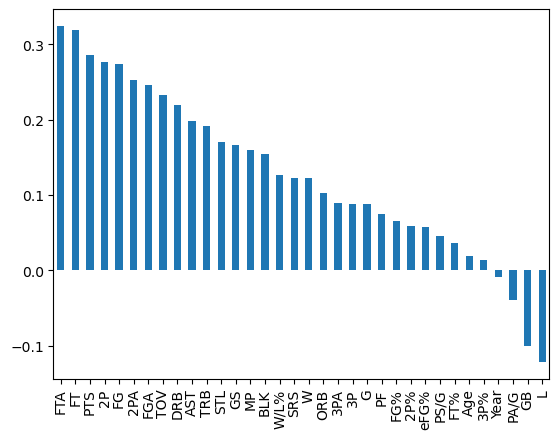

In [253]:
# Correlation only works on numerical columns
numerical_stats = stats.select_dtypes(include=['number'])

# Correlate and sort 
share_corr = numerical_columns.corr()["Share"].sort_values(ascending=False)

# Plot bar chart of correlation coeff, removing first 3 variable ("Share", "Pts Won" & "Pts Max")
share_corr[3:].plot.bar()

As expected scoring, assists, defensive rebounds and steals are highly correlated. Interestingly 3pts are significantly less correlated comapres to FT and 2pts. High team losses are negatively correlated, no suprises there.

**There is loads of visualisation that could be done with this dataset - maybe something we'll look at in Tableau in the future! For now, on to part 3!**